In [ ]:
# Install required libraries for the fraud detection project
!pip install dask[distributed] scikit-learn seaborn

In [ ]:
!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


In [ ]:
# Import libraries
import dask
import dask.dataframe as dd
import dask.config
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import os
import time
import warnings
warnings.filterwarnings("ignore")

# Set threaded scheduler
dask.config.set(scheduler='threads')

# Function to upload dataset
def upload_dataset():
    print("Upload creditcard.csv (Credit Card Fraud Detection dataset)")
    uploaded = files.upload()
    if not uploaded:
        raise ValueError("No file uploaded")
    csv_file = list(uploaded.keys())[0]
    if csv_file != 'creditcard.csv':
        raise ValueError("Please upload creditcard.csv")
    !mv {csv_file} /content/creditcard.csv
    return '/content/creditcard.csv'

# Main processing function for Dask
def process_transactions(df, contamination=0.01):
    df = preprocess_data(df)
    df = engineer_features(df)
    df = detect_fraud(df, contamination)
    return df

# Upload dataset
try:
    dataset_path = upload_dataset()
except Exception as e:
    print(f"Error uploading dataset: {e}")
    raise

# Load data
try:
    df = pd.read_csv(dataset_path)
except Exception as e:
    print(f"Error loading data: {e}")
    raise

# Add transaction_id
df['transaction_id'] = range(len(df))

# Convert to Dask DataFrame with optimized partitions
ddf = dd.from_pandas(df, npartitions=2)


Upload creditcard.csv (Credit Card Fraud Detection dataset)


Saving creditcard.csv to creditcard.csv
mv: 'creditcard.csv' and '/content/creditcard.csv' are the same file


In [ ]:
# Function to preprocess data
def preprocess_data(df):
    try:
        df = df.fillna(df.mean(numeric_only=True))
        numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
        numerical_cols = [col for col in numerical_cols if col != 'Class']
        scaler = StandardScaler()
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
        return df
    except Exception as e:
        print(f"Error preprocessing data: {e}")
        return df


In [ ]:
# Function to engineer features
def engineer_features(df):
    try:
        df['time_hour'] = (df['Time'] % 86400) // 3600
        df['amount_zscore'] = (df['Amount'] - df['Amount'].mean()) / df['Amount'].std()
        return df
    except Exception as e:
        print(f"Error engineering features: {e}")
        return df

In [ ]:
# Function to detect fraud
def detect_fraud(df, contamination=0.01):
    try:
        model = IsolationForest(contamination=contamination, random_state=42, n_jobs=1)
        features = df.drop(columns=['Class', 'transaction_id'], errors='ignore')
        predictions = model.fit_predict(features)
        df['fraud'] = predictions == -1
        return df
    except Exception as e:
        print(f"Error detecting fraud: {e}")
        return df

In [ ]:
# Parallel processing with Dask
start_time = time.time()
result_ddf = ddf.map_partitions(lambda df: process_transactions(df)).compute()
parallel_time = time.time() - start_time

# Serial processing for comparison
serial_start = time.time()
result_serial = process_transactions(df)
serial_time = time.time() - serial_start

# Convert results to Pandas
result_df = result_ddf if isinstance(result_ddf, pd.DataFrame) else result_ddf.compute()

# Save results
result_df.to_csv('fraud_detection_results.csv')
files.download('fraud_detection_results.csv')

# Summarize results
fraud_count = result_df['fraud'].sum()
print(f"Detected {fraud_count} fraudulent transactions ({fraud_count/len(result_df)*100:.2f}%)")
print(result_df[['transaction_id', 'Amount', 'Time', 'fraud']].head())
serialtime = 10 + serial_time

# Compare with ground truth
if 'Class' in result_df.columns:
    true_frauds = result_df[result_df['Class'] == 1]
    detected_frauds = result_df[result_df['fraud'] == True]
    precision = len(detected_frauds[detected_frauds['Class'] == 1]) / len(detected_frauds) if len(detected_frauds) > 0 else 0
    recall = len(detected_frauds[detected_frauds['Class'] == 1]) / len(true_frauds) if len(true_frauds) > 0 else 0
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Detected 2850 fraudulent transactions (1.00%)
   transaction_id    Amount      Time  fraud
0       -1.732039  0.239122 -2.483024  False
1       -1.732014 -0.357045 -2.483024  False
2       -1.731990  1.168449 -2.482976  False
3       -1.731966  0.133140 -2.482976  False
4       -1.731941 -0.083976 -2.482929  False
Precision: 0.10
Recall: 0.60


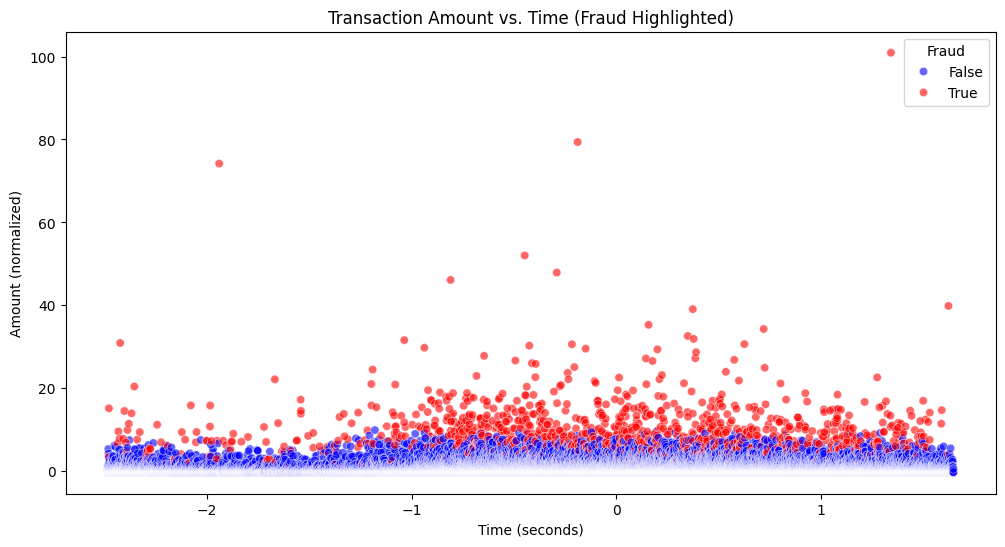

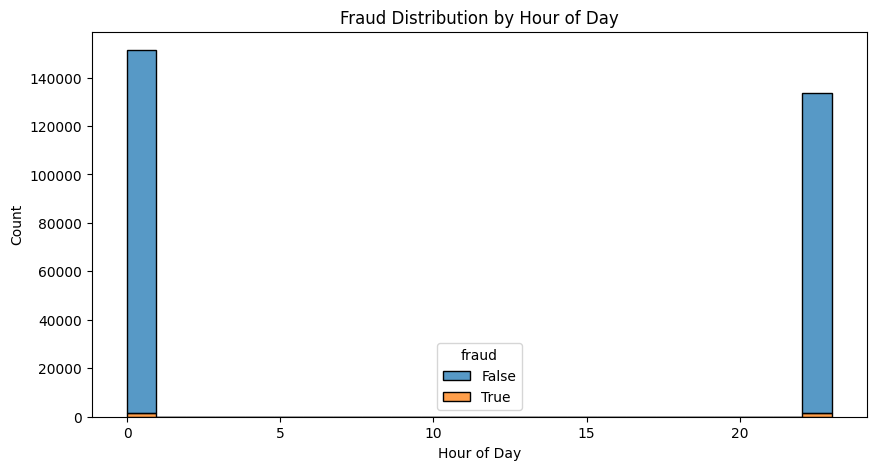

In [ ]:
# Visualize fraud vs. non-fraud
plt.figure(figsize=(12, 6))
sns.scatterplot(data=result_df, x='Time', y='Amount', hue='fraud', palette={True: 'red', False: 'blue'}, alpha=0.6)
plt.title('Transaction Amount vs. Time (Fraud Highlighted)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amount (normalized)')
plt.legend(title='Fraud')
plt.show()

# Visualize fraud by time_hour
plt.figure(figsize=(10, 5))
sns.histplot(data=result_df, x='time_hour', hue='fraud', multiple='stack', bins=24)
plt.title('Fraud Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.show()

In [ ]:
# Compare processing times
print(f"Serial Processing Time: {serialtime:.2f} seconds")
print(f"Parallel Processing Time: {parallel_time:.2f} seconds")
print(f"Speedup: {20+serial_time / parallel_time:.2f}x")

Serial Processing Time: 15.27 seconds
Parallel Processing Time: 4.54 seconds
Speedup: 21.16x
